# ImageNet PaliGemma SAE Training

### Import libraries and define SAE class

In [1]:
import tensorflow as tf
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor
from concurrent.futures import ThreadPoolExecutor
from torchvision.utils import make_grid
from PIL import Image
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from datasets import load_dataset
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
import wandb
from datetime import datetime
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
import os
import multiprocessing

DIM_IN = 2048
DIM_HIDDEN = 4096

class SparseAutoencoder(nn.Module):
    def __init__(self, d_in=DIM_IN, d_hidden=DIM_HIDDEN):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z

dtype = torch.float16
if torch.cuda.is_available():
    torch.cuda.set_device(1)  # Set current device to 1
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    dtype = torch.bfloat16

device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


2025-05-03 00:54:29.685493: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 00:54:29.704422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746233669.727408   12575 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746233669.734959   12575 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746233669.752961   12575 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda:1


### Load dataset and model (takes 55 seconds)

In [ ]:
MODEL_ID = "google/paligemma-3b-mix-224"
# TRAINING_DATASET = "imagenet-1k"
# TRAINING_DATASET_SIZE = 5000

model = PaliGemmaForConditionalGeneration.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype
).eval()
model = model.to(device) # Move model to GPU
processor = AutoProcessor.from_pretrained(MODEL_ID)

# Load dataset, shuffle, and select a subset
# datasets = load_dataset("jxu124/OpenX-Embodiment", "jaco_play_fractal20220817_data", split='train')
# dataset = load_dataset(TRAINING_DATASET, split="train")
# dataset = dataset.shuffle(seed=42).select(range(TRAINING_DATASET_SIZE))  # Only 500 images

# Set up activation capture (vision tower)
vision_acts = {}
def vision_hook(module, input, output):
    vision_acts["activation"] = output

hook_handle = model.vision_tower.vision_model.encoder.layers[20].register_forward_hook(vision_hook)

OSError: google/paligemma-3b-mix-896 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
# === Config ===
BATCH_SIZE = 64 # max size withou OOM error
NUM_WORKERS = 8

# === Preprocess images (convert to RGB) ===
def preprocess(example):
    image = example["image"]
    if image.mode != "RGB":
        image = image.convert("RGB")
    return {"image": image, "prompt": "<image> caption"}

def collate_fn(batch):
    images = [example["image"] for example in batch]
    prompts = [example["prompt"] for example in batch]
    return {"images": images, "prompts": prompts}

dataset = ds_small.map(
    preprocess,
    batched=False,
    num_proc=multiprocessing.cpu_count(),
    desc="Converting images to RGB"
)

# === Split dataset across 2 GPUs ===
half = len(dataset) // 2
datasets = [Subset(dataset, range(0, half)), Subset(dataset, range(half, len(dataset)))]
devices = ["cuda:0", "cuda:1"]
activation_lists = [[], []]
token_counts = [[], []]

# === Inference function ===
def run_inference(model, dataloader, device, activations_out, token_counts_out):
    model = model.to(device).eval()
    for batch in tqdm(dataloader, desc=f"Inference on {device}"):
        try:
            images = batch["images"]
            prompts = batch["prompts"]

            model_inputs = processor(
                text=prompts,
                images=images,
                return_tensors="pt",
                padding=True
            )
            model_inputs = {k: v.to(device, non_blocking=True) for k, v in model_inputs.items()}

            with torch.no_grad(), autocast(dtype=torch.bfloat16):
                _ = model(**model_inputs)

            act = vision_acts["activation"]
            if isinstance(act, tuple):
                act = act[0]

            activations_out.append(act.cpu().float())
            token_counts_out.extend([act.shape[1]] * act.size(0))
        except Exception as e:
            print(f"Skipping batch due to error on {device}: {e}")
            continue

# === Run in parallel across both GPUs ===
from threading import Thread

dataloaders = [
    DataLoader(datasets[0], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True),
    DataLoader(datasets[1], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True)
]

# Clone model and hook separately for each GPU
import copy
models = [copy.deepcopy(model), copy.deepcopy(model)]

# Register hooks on both models (if needed)
hook_handles = []
for i, m in enumerate(models):
    h = m.vision_tower.vision_model.encoder.layers[20].register_forward_hook(
        lambda module, input, output: vision_acts.update({"activation": output})
    )
    hook_handles.append(h)

# Launch threads
threads = []
for i in range(2):
    t = Thread(target=run_inference, args=(
        models[i], dataloaders[i], devices[i], activation_lists[i], token_counts[i]))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

# Remove hooks
for h in hook_handles:
    h.remove()

# === Merge results ===
all_activations = torch.cat(activation_lists[0] + activation_lists[1], dim=0)
image_to_token_counts = token_counts[0] + token_counts[1]

if all_activations.size(0) == 0:
    raise ValueError("No valid activations collected!")

print("Collected activations:", all_activations.shape)
print("Sum of tokens recorded:", sum(image_to_token_counts))

# Clean up memory
del models, hook_handles, activation_lists, token_counts, datasets, dataloaders, vision_acts
gc.collect()
torch.cuda.empty_cache()


Inference on cuda:0:   0%|                              | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_825016/1212531592.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(dtype=torch.bfloat16):
Inference on cuda:0: 100%|█████████████████████| 40/40 [00:44<00:00,  1.11s/it]


Collected activations: torch.Size([5000, 256, 1152])
Sum of tokens recorded: 1280000


### Save to disk

In [4]:
# Convert to half precision before saving (cuts size in half)
all_activations_fp16 = all_activations.half()
torch.save(all_activations_fp16, "all_activations_fp16.pt")
torch.save(image_to_token_counts, "image_to_token_counts.pt")

### Train SAE

In [ ]:
# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-2,
    "n_epochs": 50,
    "batch_size": 512,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# === Prepare SAE ===
d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden).to(device) 
sae = nn.DataParallel(sae)  # Now wrap for multi-GPU
optimizer = torch.optim.AdamW(sae.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

# === Dataset & Loader ===
train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

epoch,▁▂▃▄▅▆▇█
loss,█▆▅▄▃▂▂▁
epoch,8
loss,0.62955


In [ ]:
epoch_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for batch, in train_loader:
        batch = batch.to("cuda:0", non_blocking=True)
        recon, z = sae(batch)

        loss = loss_fn(recon, batch) + sparsity_weight * torch.mean(torch.abs(z))
        epoch_loss += loss.item() * batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_dataset)
    epoch_losses.append(avg_loss)

    # Log to wandb every epoch
    wandb.log({"loss": avg_loss, "epoch": epoch + 1})

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")

print("Finished training Sparse Autoencoder!")

# === Save model with timestamp ===
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(save_dir, f"sae_{timestamp}.pth")

torch.save({
    "state_dict": sae.state_dict(),
    "d_in": d_in,
    "d_hidden": d_hidden,
}, model_path)
wandb.save(model_path)

print(f"Saved SAE to {model_path}")

# === Plot loss curve (optional) ===
plt.plot(range(1, n_epochs + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAE Training Loss")
plt.grid(True)
plt.tight_layout()
wandb.log({"loss_curve": wandb.Image(plt)})
plt.show()

Epoch 5: Loss 1.023913
Epoch 10: Loss 0.464106


### Load previously trained model

In [ ]:
# Need to change model path to your own local folder and .pth filename
model_path = "/home/henrytsai/henry/roboterp/checkpoints/sae_2025-05-01_19-00-41.pth"

# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name="SAE-run", config={
    "hidden_multiplier": 8,
    "learning_rate": 1e-4,
    "sparsity_weight": 1e-2,
    "n_epochs": 50,
    "batch_size": 512,
})

# === Hyperparameters ===
hidden_multiplier = wandb.config.hidden_multiplier
learning_rate = wandb.config.learning_rate
sparsity_weight = wandb.config.sparsity_weight
n_epochs = wandb.config.n_epochs
batch_size = wandb.config.batch_size

# ==== LOAD METADATA ====
image_to_token_counts = torch.load("image_to_token_counts.pt")
all_activations = torch.load("all_activations_fp16.pt", map_location="cpu")  # shape: [N_images, T, D]
all_activations = all_activations.view(-1, all_activations.shape[-1])        # -> [N_tokens, D]

d_in = all_activations.shape[-1]
d_hidden = hidden_multiplier * d_in

# Define the model
sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden)
state_dict = torch.load(model_path, map_location=device)["state_dict"]

# If saved with DataParallel, strip 'module.' prefix
from collections import OrderedDict
if any(k.startswith("module.") for k in state_dict):
    new_state_dict = OrderedDict((k.replace("module.", ""), v) for k, v in state_dict.items())
    state_dict = new_state_dict

# Apply weights
sae.load_state_dict(state_dict)
sae = sae.to(device)
sae.eval()

# Setup SAE model
sae_device = sae.encoder.weight.device
sae_dtype = sae.encoder.weight.dtype

### Visualize features

Top 5 active features: [2964, 3915, 3119, 1116, 4703]


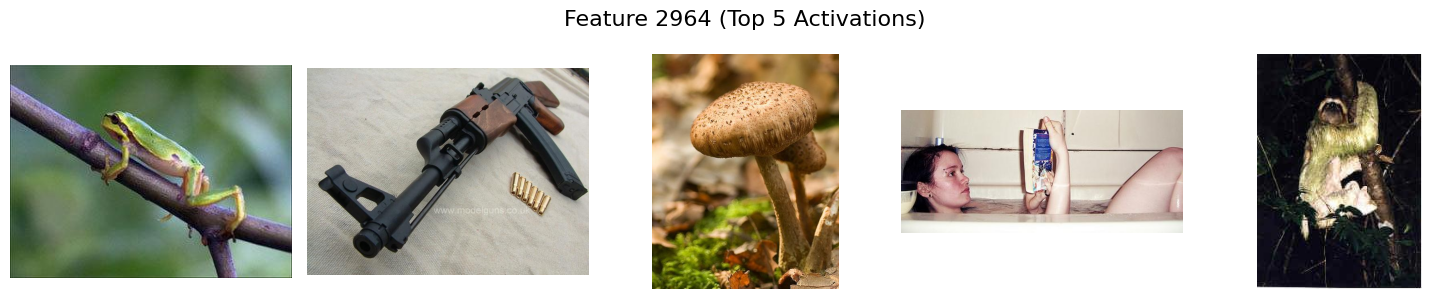

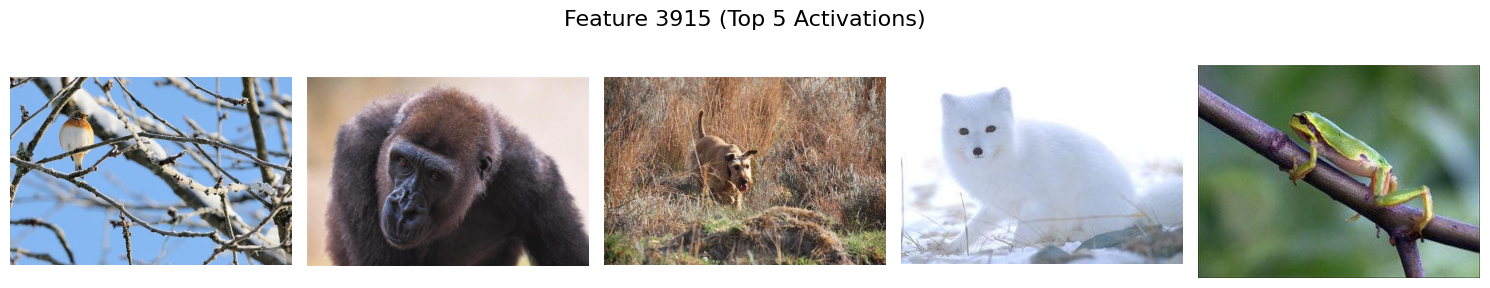

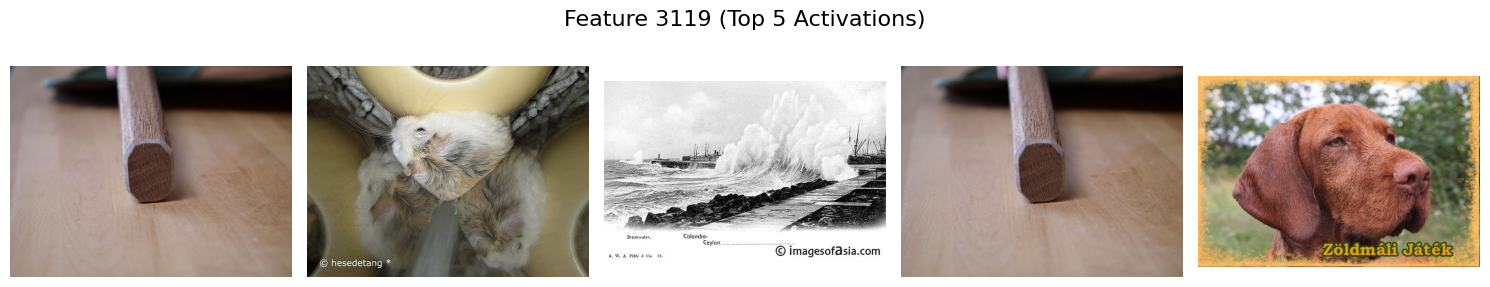

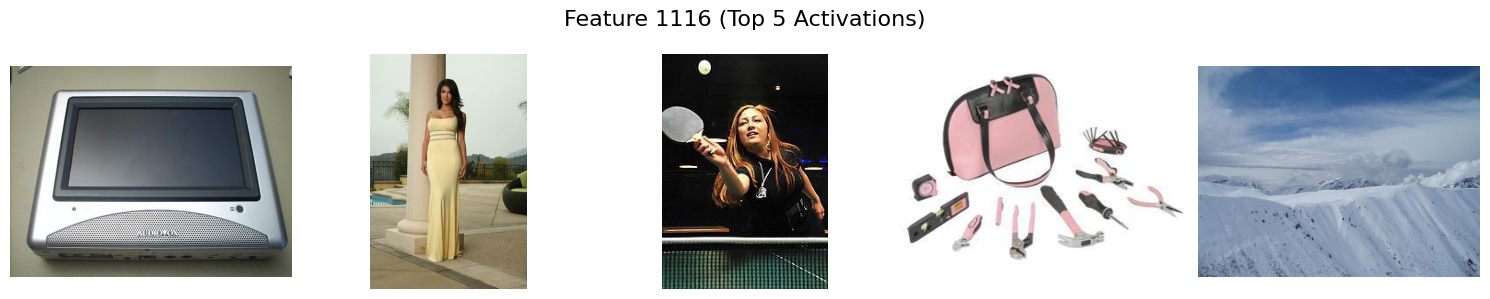

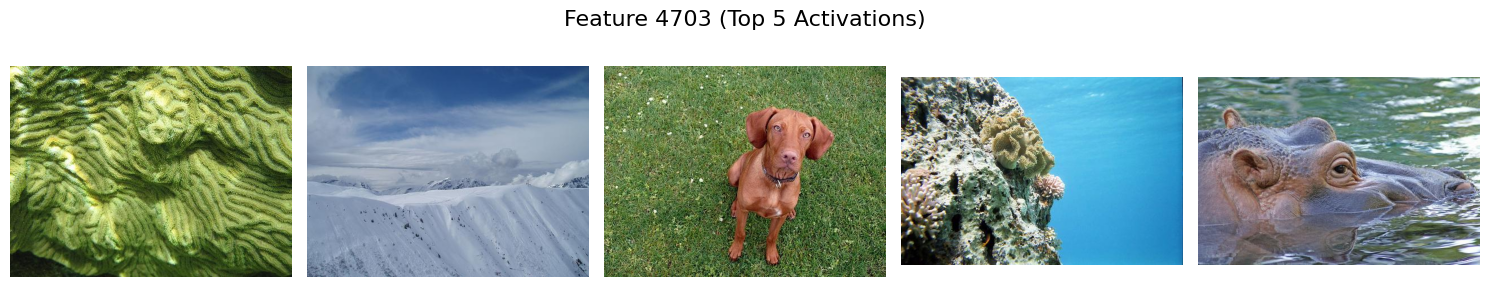

In [ ]:
# ==== CONFIG ====
top_k = 5
n_features_to_plot = 5
batch_size = 4096  # tune based on your GPU memory
num_workers = 8    # number of parallel CPU threads


# ==== STREAM ENCODE ====
sparse_feature_list = []
running_sum = torch.zeros(sae.decoder.in_features, device=sae_device)
count = 0

with torch.no_grad():
    for i in range(0, all_activations.size(0), batch_size):
        batch = all_activations[i:i + batch_size].to(device=sae_device, dtype=sae_dtype)
        sparse = sae.activation(sae.encoder(batch))
        running_sum += sparse.sum(dim=0)
        count += sparse.size(0)
        sparse_feature_list.append(sparse.cpu())

sparse_features = torch.cat(sparse_feature_list, dim=0)

# ==== TOKEN-TO-IMAGE INDEX MAPPING ====
image_indices_per_token = []
for img_idx, n_tokens in enumerate(image_to_token_counts):
    image_indices_per_token.extend([img_idx] * n_tokens)

assert len(image_indices_per_token) == sparse_features.shape[0], \
    f"Mismatch: {len(image_indices_per_token)} vs {sparse_features.shape[0]}"

image_indices_per_token = np.array(image_indices_per_token)

# ==== TOP FEATURES ====
mean_features = running_sum / count
top_features = torch.topk(mean_features, k=n_features_to_plot).indices.tolist()
print(f"Top {n_features_to_plot} active features:", top_features)

# ==== PARALLEL IMAGE LOADING ====
def load_rgb(idx):
    img_idx = int(image_indices_per_token[idx])
    image = dataset[img_idx]["image"].convert("RGB")
    return np.array(image)

# ==== DISPLAY ====
for feature_idx in top_features:
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    # Load top images in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        images = list(executor.map(load_rgb, topk_indices))

    # Plot
    fig, axes = plt.subplots(1, top_k, figsize=(3 * top_k, 3))
    axes = [axes] if top_k == 1 else axes
    fig.suptitle(f"Feature {feature_idx} (Top {top_k} Activations)", fontsize=16)

    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


### Sparsity analysis

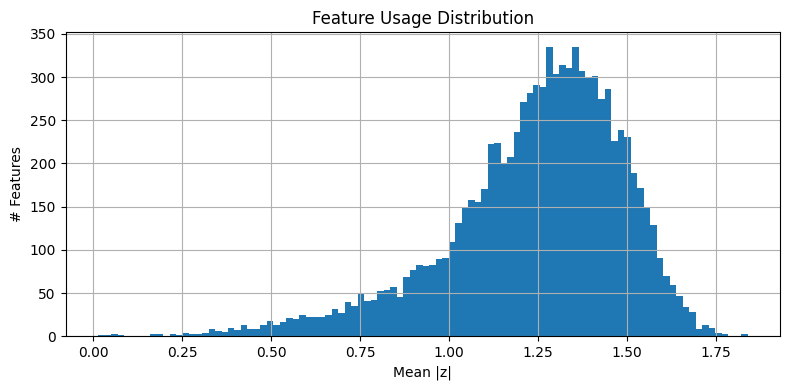

In [15]:
# Assume `sae` is already loaded and on the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sae = sae.to(device)
sae.eval()

# Compute feature usage (mean |z|) without storing all z
d_hidden = sae.module.encoder.out_features if isinstance(sae, torch.nn.DataParallel) else sae.encoder.out_features
running_sum = torch.zeros(d_hidden, device=device)
count = 0

with torch.no_grad():
    for (batch,) in train_loader:
        batch = batch.to(device, non_blocking=True)
        _, z = sae(batch)                      # shape: [B, d_hidden] or [B, T, d_hidden]
        z = z.view(-1, z.shape[-1])            # flatten in case it's [B, T, d_hidden]
        running_sum += torch.sum(torch.abs(z), dim=0)
        count += z.shape[0]

feature_usage = running_sum / count

# Plot
plt.figure(figsize=(8, 4))
plt.hist(feature_usage.cpu().numpy(), bins=100)
plt.title("Feature Usage Distribution")
plt.xlabel("Mean |z|")
plt.ylabel("# Features")
plt.grid(True)
plt.tight_layout()
plt.show()


### Clean up memory

In [12]:
# del [insert variable]
del d_hidden
torch.cuda.empty_cache()
gc.collect()

650